In [1]:

#by Henry Schumacher
#-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-#
import os
import sys
import json
import uuid
import time
import xraydb
import plotly
#-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-#
import numpy as np
import pandas as pd
# import pyxray as xy
import seaborn as sb
#-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-#
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from getmac import get_mac_address as gma
#-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-#
from matplotlib import rc
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times"],
    "text.usetex": True,
    "font.size": 8,
    "pgf.rcfonts": False
})
# rc('font',**{'family':'serif','serif':['Times']})
# rc('text', usetex=True)
# plt.rcParams.update({'font.size': 8})

plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "pgf.preamble": "\n".join([
          r"\usepackage{mathtools}",
     ]),
})
#-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-#
def dual_print(output, txt):
    print(txt)
    with open(output, 'a') as out:
        print(txt, file=out)
#-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-#
from RootToPythonConverter.json_to_np import *
from DataToHistoConverter.csv_to_npHisto import *
from RootToPythonConverter.colors import load_colors
#-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-o-#


mac = gma()
print(f"MAC address: {mac}")

mac_dict = {'f4:b5:20:5e:ba:f2': ['C://Users//schum//Documents//Filing Cabinet//1_RootFilesGeant4', 'C://Users//schum//Documents//Filing Cabinet//2_jsonFiles'], # Office
            '14:5a:fc:4f:e8:35': ['D://root_files_temp_storage', 'D://json_files_temp_storage'], # Laptop
            '0x1a7dda7115'  : ['B://IBA//root', 'B://IBA//json']} # Home PC
# Each mac adresse leads to a pair of paths, the first being the folder, 
# where the root files are, the second, where the json files are supposed to be stored
# root_path = mac_dict[mac][0]
json_path = mac_dict[mac][1]

color_schemes = load_colors()
print(color_schemes)

time.strftime("Kernel started: %a, %d %b %Y %H:%M:%S", time.localtime())

MAC address: f4:b5:20:5e:ba:f2
{'c_rainbow': ['#690000', '#C1292E', '#e08e45', '#E0BE36', '#7A8C2A', '#0D863D', '#2d82b7', '#740091'], 'c_complementary': ['#D90368', '#4C5395', '#2CDA9D', '#FA824C', '#3C91E6', '#FFBA08', '#009528', '#6689C6'], 'c_violetorange': ['#5E0ABF', '#701AA4', '#82298A', '#94396F', '#A64854', '#B85839', '#CA671F', '#DC7704'], 'c_five': ['#FFBA08', '#E05A5F', '#3D405B', '#81B29A', '#C45AB3']}


'Kernel started: Mon, 08 Sep 2025 14:27:08'

In [2]:
def logger(keyword, key_value, logfile_path, func):
    logfile_name = 'log_'
    timestamp = time.strftime("%Y%m%d_%H%M%S", time.localtime())
    logfile_name += f'{timestamp}.txt'
    print(logfile_name)
    print(time.time.__name__)
    return f'INFO: logfile {logfile_path}//{logfile_name} done'

logger(1,1,json_path, load_colors())

log_20250908_142709.txt
time


'INFO: logfile C://Users//schum//Documents//Filing Cabinet//2_jsonFiles//log_20250908_142709.txt done'

In [3]:
PARAM_XRAY_L = {'mask_min': 0.,     # Minimum Edge
              'mask_max':0.01,      # 10 keV 
              'title': 'X-ray spectrum up to 10 keV',
              'peak_height': 10     # Peak height for detection
              }

PARAM_XRAY_S = {'mask_min': 0.,     # Minimum Edge
              'mask_max':0.015,     # 15 keV 
              'title': 'X-ray spectrum up to 15 keV (SEM)',
              'peak_height': 10     # Peak height for detection
              }

PARAM_XRAY_H = {'mask_min': 0.,     # Minimum Edge
              'mask_max':0.1,       # 10 keV 
              'title': 'X-ray spectrum up to 100 keV',
              'peak_height': 100    # Peak height for detection
              }

PARAM_GAMMA = {'mask_min': 0.,
               'mask_max': 2.,
               'title': 'Gamma spectrum up to 2 MeV',
               'peak_height': 1   # Peak height for detection
              }
PARAM_RBS = {'mask_min': 0.,
               'mask_max': 28.,
               'title': 'RBS spectrum up to 28 MeV',
               'peak_height': 1   # Peak height for detection
              }

In [4]:
def xray_line_searcher(energy_low, energy_high):
    '''
    energy_low/high: in eV
    '''
    matching = []
    xray_line_path = './/xraylines.json'
    
    if (xraydb.xray_lines('Fe') != {}):
        for Z in range(1, 101):  # Elements from Hydrogen (Z=1) to Fermium (Z=100)
            element = xraydb.atomic_symbol(Z)
            # Get all known X-ray lines for the element
            try:
                lines = xraydb.xray_lines(element)
            except Exception:
                continue  # Skip elements that don't have data
            
            # print(lines)
            for line_id, line in lines.items():
                line_energy = line.energy  # Energy in keV
                if (energy_low <= line_energy and line_energy <= energy_high):
                    matching.append({
                        'element': element,
                        'Z': Z,
                        'transition': line_id,
                        'energy_eV': line_energy,
                        'intensity': line.intensity
                    })
    else: #the data extraction has to be fixed.
        with open(xray_line_path, "r") as j:
            xraydata = json.load(j)
        for Z in range(1,101):
            element = xraydb.atomic_symbol(Z)
            try:
                lines = xraydata[element]
            except Exception:
                continue
            
            for line_id, line in lines.items():
                line_energy = line.energy  # Energy in keV
                if (energy_low <= line_energy and line_energy <= energy_high):
                    matching.append({
                        'element': element,
                        'Z': Z,
                        'transition': line_id,
                        'energy_eV': line_energy,
                        'intensity': line.intensity
                    })

    return matching

In [5]:
def peak_text_prompter(peaks, bin_edges, output_file_name, info,side='both'):
    '''
    Energies from this function are in keV! \n
    '''
    energy_bins = {}
    ofn = output_file_name
    
    dual_print(ofn,'--'.ljust(80,'-'))
    dual_print(ofn, info)
    dual_print(ofn,'--'.ljust(80,'-'))
    dual_print(ofn,'Bin'.ljust(8) + '| ' + 'E_range (eV)'.ljust(18) + '| ' + 'El.'.ljust(4)  + '| ' + 'Line'.ljust(6) + '| ' + 'Energy (eV)'.ljust(12) + '| ' + 'Int.'.ljust(6))
    
    for p in peaks:
        if (side == 'both'):
            energy_bins[p] = [bin_edges[p-1], bin_edges[p], bin_edges[p+1]]
            
            E_low = round(energy_bins[p][0]*10**6,4)
            E_high = round(energy_bins[p][1]*10**6,4)
            matching = xray_line_searcher(E_low, E_high)
            # print(matching[0])
            # print(energy_bins[p])
            dual_print(ofn,f'Bin {p-1}'.ljust(8) + '| ' + f'{round(energy_bins[p][0]*10**6,1)} - {round(energy_bins[p][1]*10**6,1)}'.ljust(18) + '| ' + '-'.ljust(33,'-'))
            
            for line in matching:
                dual_print(ofn,''.ljust(28) + '| ' + str(line['element']).ljust(4) + '| ' + str(line['transition']).ljust(6) + '| ' + str(line['energy_eV']).ljust(12) + '| ' + str(round(line['intensity'],3)).ljust(6))
            
            E_low = round(energy_bins[p][1]*10**6,4)
            E_high = round(energy_bins[p][2]*10**6,4)
            matching = xray_line_searcher(E_low, E_high)
            # print(matching[0])
            # print(energy_bins[p])
            dual_print(ofn,f'Bin {p}'.ljust(8) + '| ' + f'{round(energy_bins[p][1]*10**6,1)} - {round(energy_bins[p][2]*10**6,1)}'.ljust(18) + '| ' + '-'.ljust(33,'-'))
        
            for line in matching:
                dual_print(ofn,''.ljust(28) + '| ' + str(line['element']).ljust(4) + '| ' + str(line['transition']).ljust(6) + '| ' + str(line['energy_eV']).ljust(12) + '| ' + str(round(line['intensity'],3)).ljust(6))
    return True

#print(t[2].ljust(30) + '| ' + t[5].ljust(20) + '| ' + t[4].ljust(32) + '| ' + longstop.ljust(32) + '| ' + t[0].ljust(10) + '| ' + ''.ljust(10) + '| ' + '\n' + '--'.ljust(145,'-'))

In [6]:
def array_to_histo(prm, data, mask_min = 0., mask_max = 0.015, FS = (5,3), energy_res = 0.00012, yscale = 'linear', histotype = 'numpy'):
    '''
    MANDATORY: \n
    prm = set of parameters [PARAM_XRAY_L, PARAM_XRAY_H, PARAM_GAMMA] \n
    data = numpy array / pd.DataFrame \n
    OPTIONAL: \n
    mask_max = float; in MeV \n
    FS = figsize \n
    energy_res = float; in MeV \n
    yscale = ['linear', 'log'] \n
    histotype = ['numpy', 'csv']
    '''
    if prm != {}:
        mask_min = prm['mask_min']
        mask_max = prm['mask_max']
        title = prm['title']
        peak_height = prm['peak_height']
    
    plt.figure(figsize=FS, dpi=300)
    
    if (histotype == 'numpy'):
        B = int(mask_max/energy_res - mask_min/energy_res)
        print(B)
        min_cut_data = data[data >= mask_min]
        counts, bin_edges = np.histogram(min_cut_data[min_cut_data <= mask_max], bins=B)
        delta_bin = abs(bin_edges[0] - bin_edges[1])

        # print("Counts:", counts)
        # print("Bin edges:", bin_edges)
        peaks, properties = find_peaks(counts, height=peak_height)
        # print(peaks)
                
        if (B < 250 or prm != PARAM_RBS):
            plt.hist(min_cut_data[min_cut_data <= mask_max], bins=B, color="#C6C6C6", edgecolor='#C6C6C6', zorder=2, label='Full spectrum')
        
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        selected_counts = counts[peaks]
        selected_centers = bin_centers[peaks]
        selected_widths = np.diff(bin_edges)[peaks]

        # Plot only selected bins as a bar chart
        plt.bar(selected_centers, selected_counts, width=selected_widths, color="#0F50B2", edgecolor='#0F50B2', zorder=3, label='Peaks')
        if (B < 250):
            for b in range(len(selected_centers)):
                plt.text(x=bin_edges[peaks][b], y=selected_counts[b]*1.2, s=f'Bin {peaks[b]}', fontdict={'fontsize':7, 'rotation':90})
            peak_text_prompter(peaks, bin_edges, 'xxx.txt')
        # plt.plot(bin_edges[peaks]+ delta_bin/2, counts[peaks], 'bx', label='Prominent Peaks')
        plt.xlabel(r'$E_{\mathrm{kin}}^{\gamma}$ in MeV')
        plt.ylabel('Counts')
        plt.yscale(yscale)
        if (yscale == 'linear'):
            plt.ylim(0,np.max(counts)*1.2)
        else:
            plt.ylim(8*10**(-1),np.max(counts)*4)
        plt.xlim(mask_min,mask_max)
        plt.legend()
        plt.title(title)
        plt.grid(True, zorder=1, alpha=0.25)
        plt.tight_layout()
        plt.show()
        peak_text_prompter(peaks, bin_edges, delta_bin)
        
    elif (histotype == 'csv'):
        energy = data['Energy [eV]']
        counts = data['Counts']
        plt.step(energy, counts, where="mid", label='Spectrum')
        plt.xlabel(r'$E_{\mathrm{kin}}^{\gamma}$ in eV')
        plt.ylabel('Counts')
        plt.yscale(yscale)
        if (yscale == 'linear'):
            plt.ylim(0,np.max(counts)*1.2)
        else:
            plt.ylim(8*10**(-1),np.max(counts)*4)
        plt.xlim(mask_min*10**6,mask_max*10**6)
        plt.legend()
        plt.title(title)
        plt.grid(True, zorder=1, alpha=0.25)
        plt.tight_layout()
        plt.show()
        
    return 100

In [7]:
def nD_histogram(data, nD):
    if (type(data) != dict):
        pass #ARRAY
    else:
        df = pd.DataFrame({
            'theta': data['theta'],
            'phi': data['phi']
        })
        plt.figure(figsize=(6,4), dpi=250)
        sb.histplot(data=df, x='theta', y='phi', bins=50, cbar=True, cmap='viridis')
        # Customize labels and title
        plt.title("2D Heatmap of Spherical Angles theta and phi")
        plt.xlabel("theta (radians)")
        plt.ylabel("phi (radians)")

        # Show plot
        plt.tight_layout()
        plt.show()
    return 42

In [8]:
def single_histo_to_line(prm, data):
    if prm != {}:
        mask_min = prm['mask_min']
        mask_max = prm['mask_max']
        title = prm['title']
        peak_height = prm['peak_height']
    
    B = int(mask_max/0.00012 - mask_min/0.00012)
    # print(B)
    min_cut_data = data[data >= mask_min]
    counts, bin_edges = np.histogram(min_cut_data[min_cut_data <= mask_max], bins=B)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    # plt.figure()
    # plt.plot(bin_centers,counts,lw=1,color=color_schemes['c_complementary'][0])
    # plt.show()
    return bin_edges, counts, B
    
def multi_histo(prm,files):
    if prm != {}:
        mask_min = prm['mask_min']
        mask_max = prm['mask_max']
        title = prm['title']
        peak_height = prm['peak_height']
    data_dict = {}
    plt.figure(figsize=(5,3), dpi=300)
    i = 0
    for file in files:
        data = json_to_np(json_file_path=json_path + file,json_field='Ekin')
        min_cut_data = data[data >= mask_min]
        print(f'Data set loaded: {i+1}/{len(files)}')
        be, co, B = single_histo_to_line(prm=prm, data=data)
        dictkey1 = file + 'be'
        dictkey2 = file + 'co'
        data_dict[dictkey1] = be
        data_dict[dictkey2] = co
        plt.hist(min_cut_data[min_cut_data <= mask_max], bins=B, color=color_schemes['c_complementary'][i], edgecolor='black', label=file)
        plt.yscale('log')
        i += 1
    
    plt.show()
    
    return data_dict

In [9]:
def Load_Data(file_name, opt = None):
    suffix = file_name.split('.')[-1]
    if (suffix == 'csv'):
        if (opt == None):
            data_df = pd.read_csv(file_name, delimiter=';',header=7)
            return data_df
        elif (opt == 'histo'):
            data_histo = csv_to_npHisto(file_name)
            return data_histo
    if (suffix == 'json'):
        data = json_to_np(json_path + file_name , json_field='all')
        return data

In [10]:
def sumexp_fit(data, degree=4, x_offset=0.0):
    x_fit = data['Energy [eV]'][data['Counts'] > 0] - x_offset
    y_fit = np.log(data['Counts'][data['Counts'] > 0])
    
    coeffs = np.polyfit(x_fit, y_fit, degree)
    
    a, b, c, d, e = coeffs[::-1]
    print("Fit coefficients:")
    print(f"a={a}, b={b}, c={c}, d={d}, e={e}")
    
    
    y_pred = np.exp(a + b*x_fit + c*x_fit**2 + d*x_fit**3 + e*x_fit**4)
    return x_fit, y_pred

In [23]:
def multi_spectra_single_plot(files, dictnames, logfile_name):
    colors = color_schemes['c_complementary']
    plt.figure(figsize=(7,4), dpi=300)
    timestamp = time.strftime("%Y%m%d_%H%M%S", time.localtime())
    
    for file in range(len(files)):
        df = Load_Data(file_name=files[file])
        x = df['Energy [eV]']
        y = df['Counts']
        corry = np.log(np.max(y)/(0.825*10**2))
        print(corry)
        corr = np.exp((corry) - 5*10**(-4)*x)
        
        peaks, properties = find_peaks(y, height=1000, prominence=300)
        plt.errorbar(x[peaks], y[peaks], xerr=10, lw=0.5, fmt='x', color=colors[file], alpha=0.75, markersize=4, capsize=2, zorder=3)
        print(x[peaks])
        plt.plot(x,corr, color='black', lw=0.4, ls=':', zorder=2)
        # plt.plot(x,y-(corr), color=colors[file], lw=0.8, label=f"Bkgd reduced {dictnames[file]}", zorder=3)
        # if (file != 0):
        #     label2=r' Count = $2 \cdot 10^6$'
        # else:
        #     label2=r' Count = $1 \cdot 10^7$'
        plt.plot(df['Energy [eV]'], df['Counts'],
                 lw=0.75, ls='-',
                 color=colors[file], label= dictnames[file],
                 zorder=2)
        
        xk = x/10**6
        peak_text_prompter(peaks, xk, output_file_name=f'{logfile_name}_{timestamp}.txt', info=files[file], side='both')
        
    bkgr_label = r'$f(x) = \mathrm{exp}\{\mathrm{ln}((\mathrm{max}(y)/82.5)) - 5 \cdot 10^{-4}x\}$'
    plt.plot([],[], lw=0.4, ls=':', label=bkgr_label, color='black')
    plt.grid()
    plt.legend(fontsize=6)
    
    plt.xscale('linear')
    plt.xlim(0,4000)
    plt.xlabel('Energy in eV')
    
    plt.yscale('log')
    plt.ylim(100,2*10**6)
    plt.ylabel('Counts')
    
    plt.title('X-ray spectrum of Columbian Coffee samples')
        
        
    return 'Done'  
    

9.453814040672723
27      280
38      390
52      530
67      680
125    1260
149    1500
176    1770
200    2010
230    2310
331    3320
Name: Energy [eV], dtype: int64
--------------------------------------------------------------------------------
.//Study_2508_Coffee//data//Holm_Kol_Bohne.csv
--------------------------------------------------------------------------------
Bin     | E_range (eV)      | El. | Line  | Energy (eV) | Int.  
Bin 26  | 270.0 - 280.0     | ---------------------------------
                            | C   | Ka2   | 277.0       | 0.334 
                            | C   | Ka1   | 277.0       | 0.666 
Bin 27  | 280.0 - 290.0     | ---------------------------------
                            | Pd  | Mz    | 284.8       | 1.0   
Bin 37  | 380.0 - 390.0     | ---------------------------------
Bin 38  | 390.0 - 400.0     | ---------------------------------
                            | N   | Ka2   | 392.4       | 0.334 
                            | N   | Ka1 

'Done'

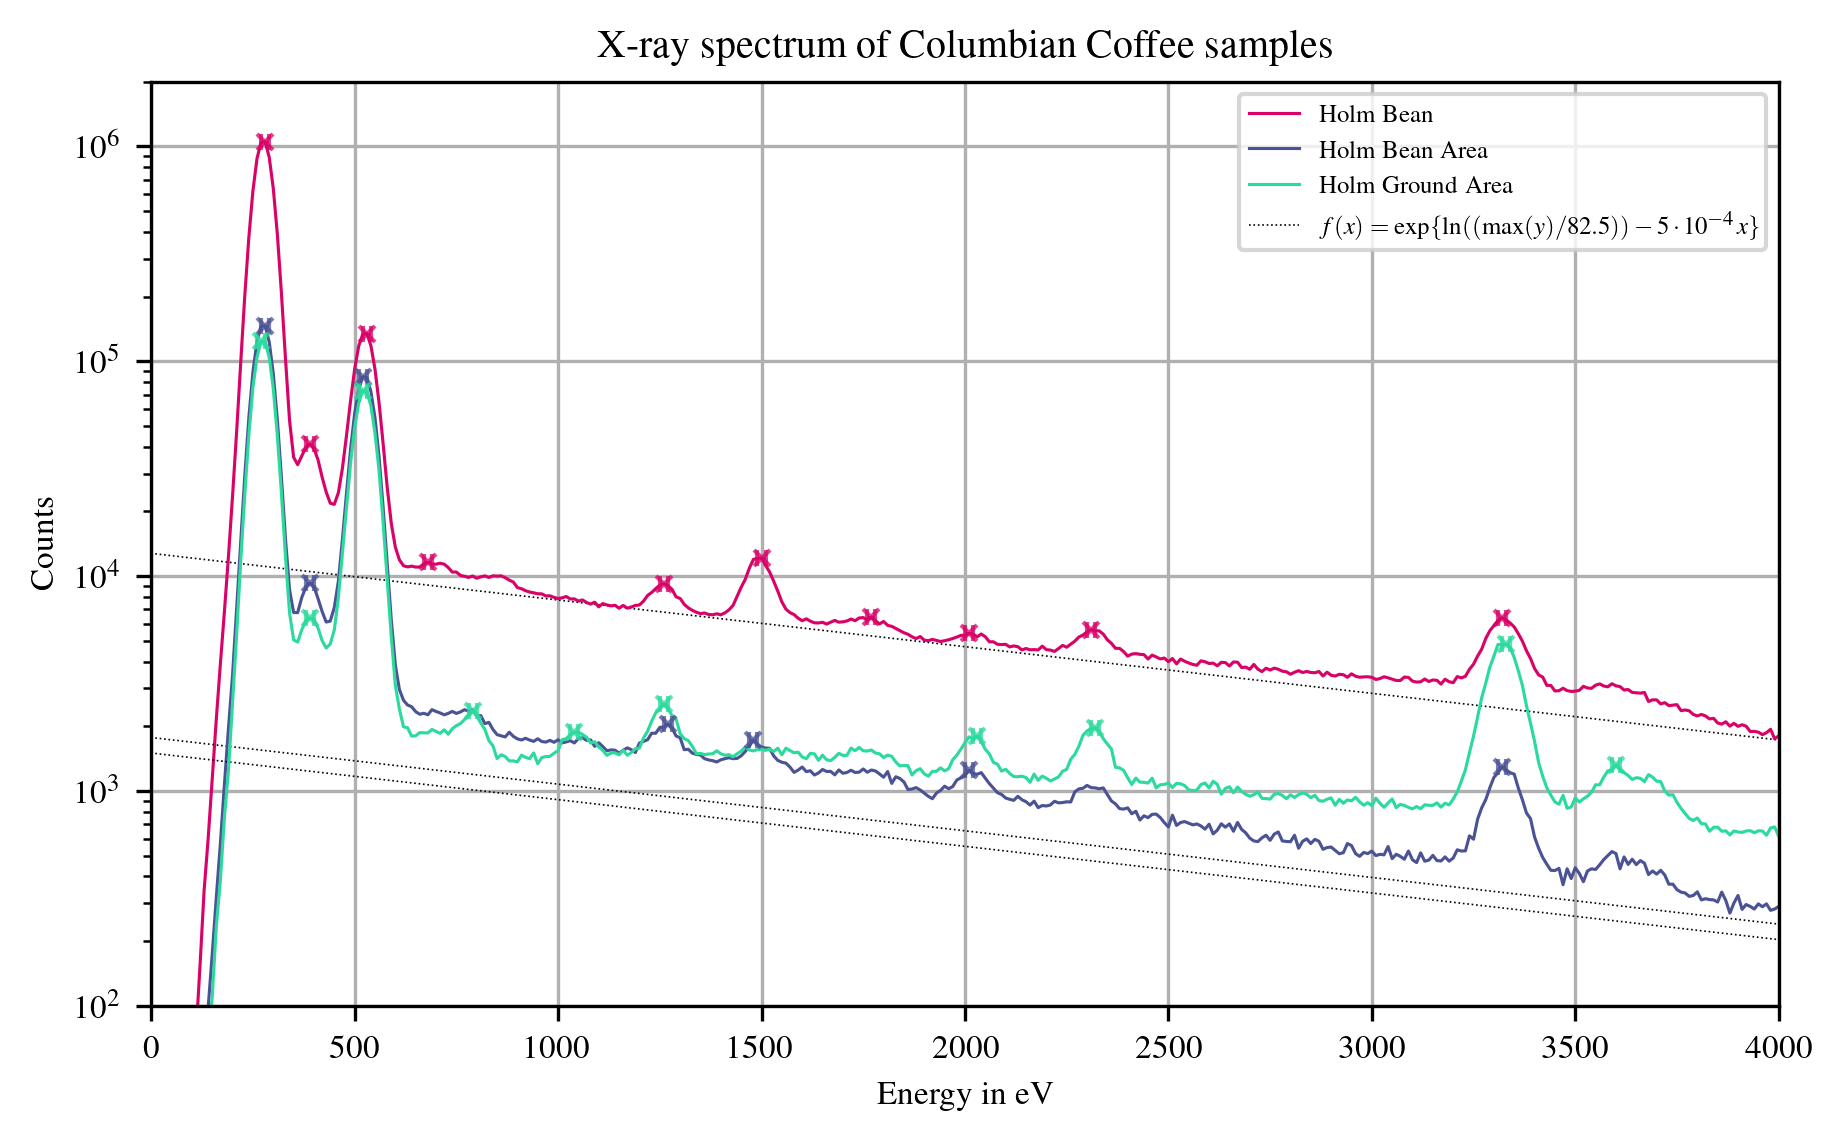

In [24]:
#Coffee Study Columbian
files = ['.//Study_2508_Coffee//data//Holm_Kol_Bohne.csv',
         './/Study_2508_Coffee/data//Holm_Kol_Bohne_A.csv',
         './/Study_2508_Coffee//data//Holm_Kol_Gemahlen_A.csv']
dictnames = ['Holm Bean','Holm Bean Area', 'Holm Ground Area']

multi_spectra_single_plot(files, dictnames, logfile_name=".//Study_2508_Coffee//Holm_Coffee_Peaks")


7.558918173661225
26      270
38      390
51      520
125    1260
149    1500
Name: Energy [eV], dtype: int64
--------------------------------------------------------------------------------
.//Study_2508_Coffee//data//RCVT_grBohne_A.csv
--------------------------------------------------------------------------------
Bin     | E_range (eV)      | El. | Line  | Energy (eV) | Int.  
Bin 25  | 260.0 - 270.0     | ---------------------------------
                            | C   | Ka3   | 266.2       | 0.0   
                            | Cl  | Lb4   | 260.0       | 0.414 
                            | Cl  | Lb3   | 260.0       | 0.586 
                            | K   | Ln    | 262.5       | 1.0   
                            | Rh  | Mz    | 261.4       | 1.0   
Bin 26  | 270.0 - 280.0     | ---------------------------------
                            | C   | Ka2   | 277.0       | 0.334 
                            | C   | Ka1   | 277.0       | 0.666 
Bin 37  | 380.0 - 390.0     | ---

'Done'

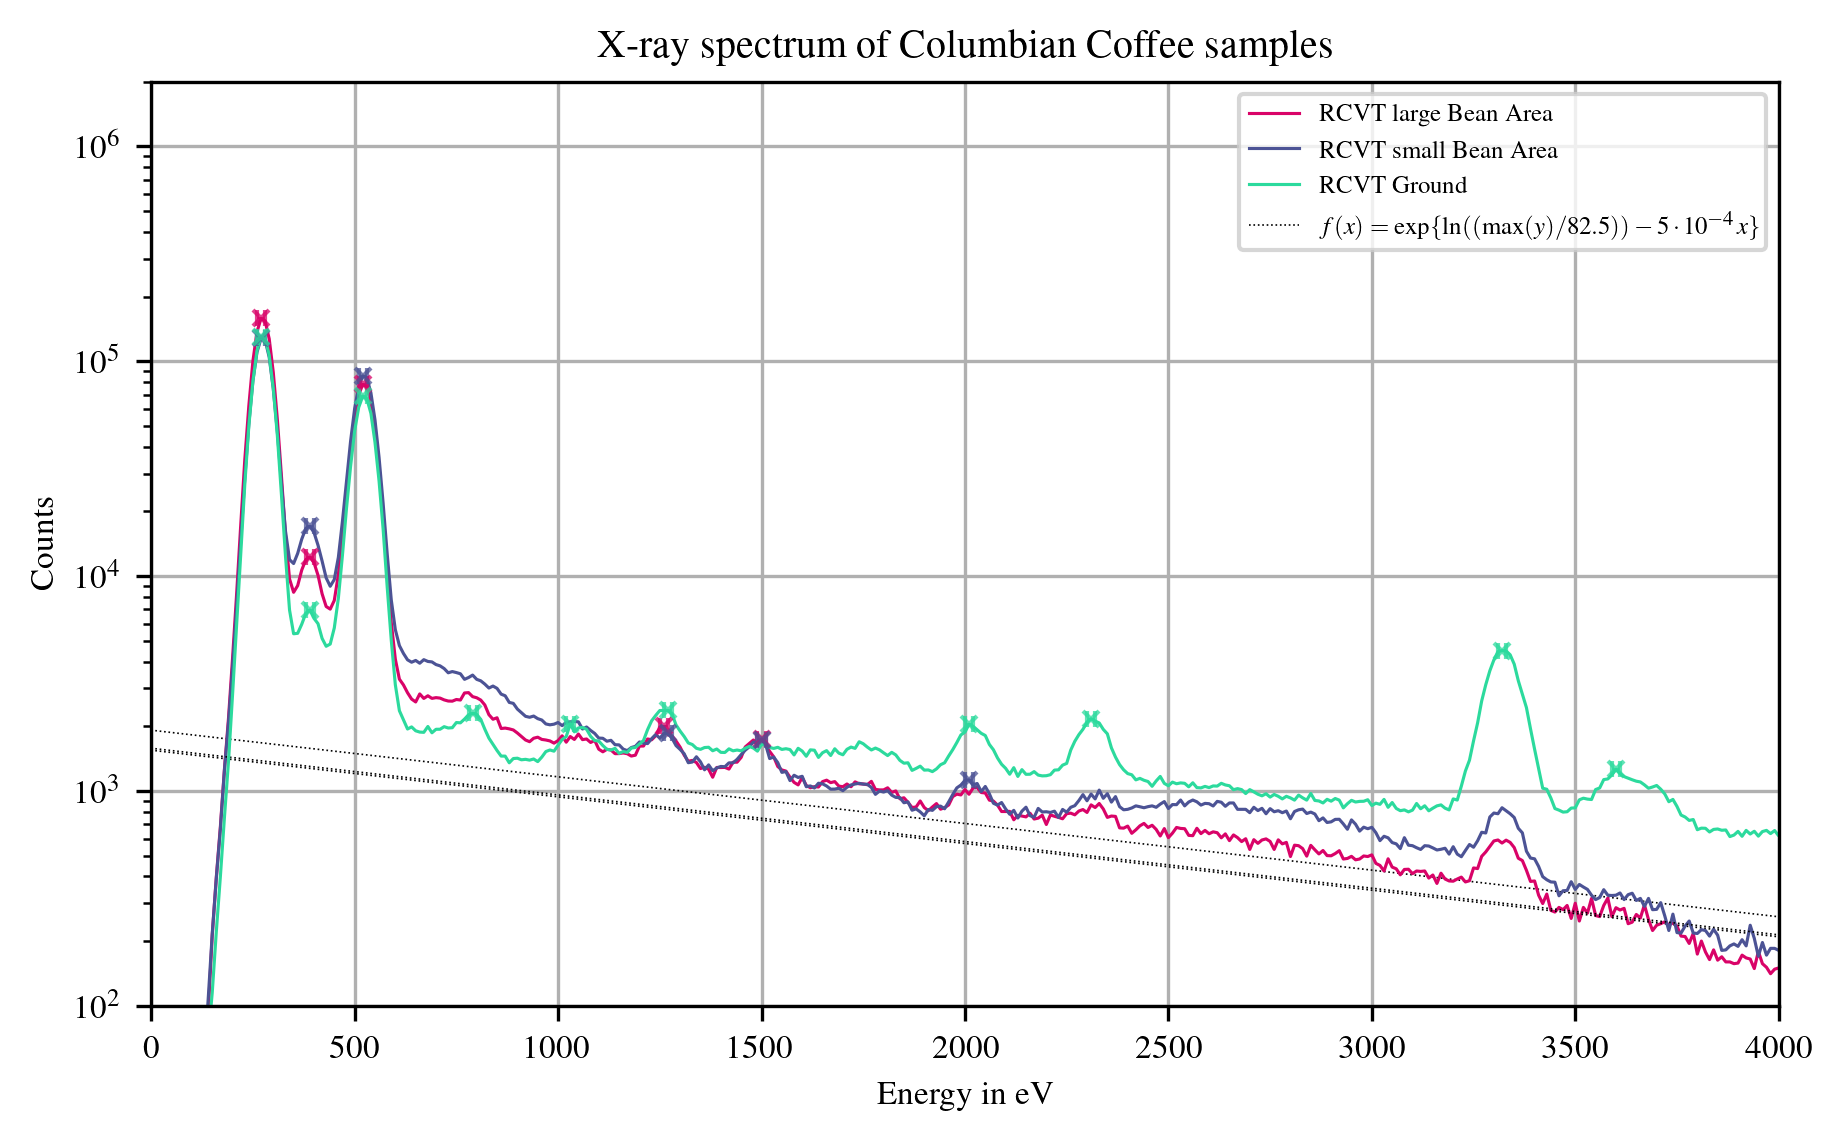

In [26]:
#Coffee Study RCVT
files = ['.//Study_2508_Coffee//data//RCVT_grBohne_A.csv',
         './/Study_2508_Coffee/data//RCVT_klBohne_A.csv',
         './/Study_2508_Coffee//data//RCVT_gemahlen.csv']
dictnames = ['RCVT large Bean Area','RCVT small Bean Area', 'RCVT Ground']

multi_spectra_single_plot(files, dictnames, logfile_name=".//Study_2508_Coffee//RCVT_Coffee_Peaks")


In [13]:
# data = json_to_np(json_path + "//Col_Coffee_alpha_28-0_17636_RBS_1.json" , json_field='all')
data = json_to_np(json_path + '//Col_Coffee_alpha_28-0_17636_PIXE_1.json', json_field='all')
# print(np.max(data['Ekin']))


False


FileNotFoundError: [Errno 2] No such file or directory: 'C://Users//schum//Documents//Filing Cabinet//2_jsonFiles//Col_Coffee_alpha_28-0_17636_PIXE_1.json'

{'theta': array([0.52586788, 1.92210751, 0.70402575, ..., 2.38557551, 0.44703632,
       2.76620871], shape=(3390,)), 'phi': array([-0.98571324, -0.74903665, -1.66804198, ...,  2.83822364,
       -2.2094715 , -1.46216138], shape=(3390,))}


2

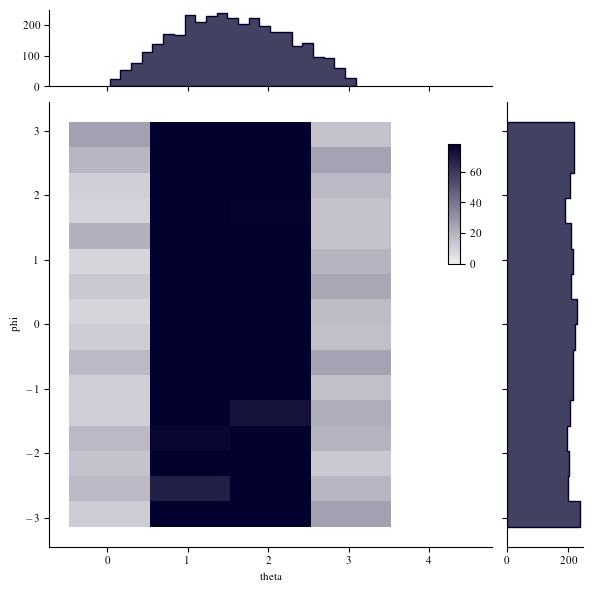

In [ ]:
def full_histo_suite(data):
    """
    PARAMETER:\n
    
    RETURN:\n
    
    PLOT-FORMAT:\n
    1   2\n
    3   4
    """
    g = sb.JointGrid(data=data, x="theta", y="phi", marginal_ticks=True)
    # Create an inset legend for the histogram colorbar
    cax = g.figure.add_axes([.75, .55, .02, .2])

    # Add the joint and marginal histogram plots
    g.plot_joint(
        sb.histplot, discrete=(True, False),
        cmap="light:#03012d", pmax=.25, cbar=True, cbar_ax=cax
    )
    g.plot_marginals(sb.histplot, element="step", color="#03012d")
    return 2

angular_data = data
angular_data.pop('Ekin',None)
print(angular_data)
full_histo_suite(data=angular_data)

16666


C:\Users\schum\AppData\Local\Temp\ipykernel_27616\1739339603.py:52: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(0,np.max(counts)*1.2)
C:\Users\schum\AppData\Local\Temp\ipykernel_27616\1739339603.py:59: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


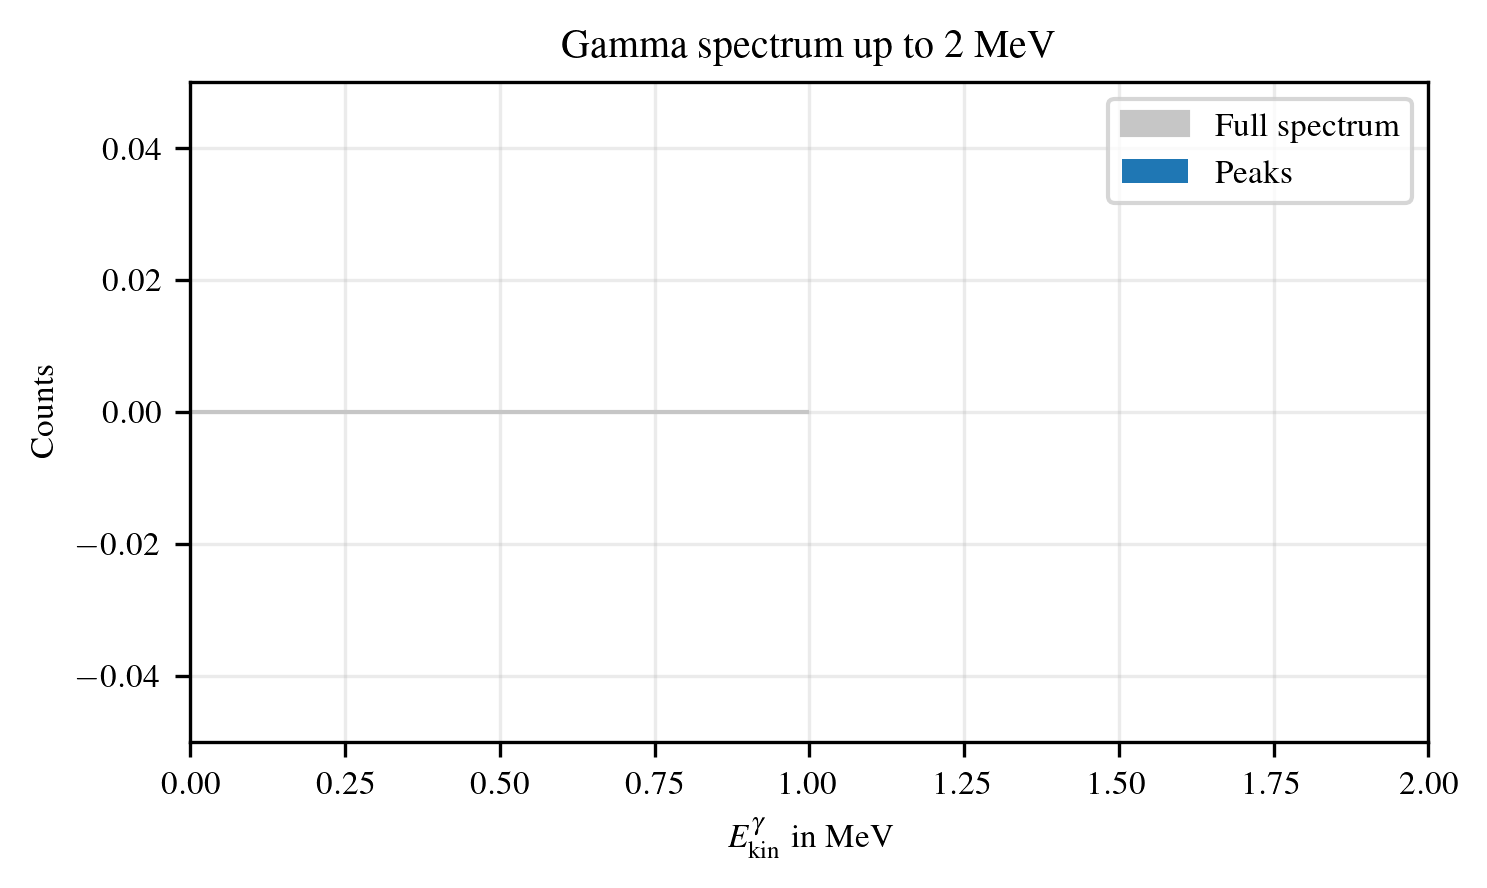

--------------------------------------------------------------------------------
Bin     | E_range (eV)      | El. | Line  | Energy (eV) | Int.  


100

In [ ]:
# files = ['//YBCO_10mu_proton_7-0_25044_PIXE_1.json',
#          '//YBCO_10mu_proton_8-5_20760_PIXE_1.json',
#          '//YBCO_10mu_proton_10-0_9848_PIXE_1.json',
#          '//YBCO_10mu_proton_12-0_26620_PIXE_1.json',
#          '//YBCO_10mu_proton_14-0_19704_PIXE_1.json']
# multi_histo(prm=PARAM_XRAY_L, files=files)
array_to_histo(PARAM_GAMMA, data['Ekin'][::100],yscale='linear')
# array_to_histo(data['Ekin'], mask_max=520)

In [ ]:
# Use this for interactive spectrum visualizer
import plotly.graph_objects as go
import numpy as np

# Line data
x = np.linspace(0, 10, 100)
y = np.cos(x)

# Special points
special_x = [2, 5, 8]
special_y = np.cos(special_x)

# Arbitrary metadata for each point
ids = [101, 102, 103]
comments = ["First peak", "Zero crossing", "Trough"]

# Create figure
fig = go.Figure()

# Add line
fig.add_trace(go.Scatter(
    x=x, y=y,
    mode="lines",
    name="Line",
    line=dict(color="blue")
))

# Add special points with custom metadata in hover
fig.add_trace(go.Scatter(
    x=special_x, 
    y=special_y,
    mode="markers",
    name="Special Points",
    marker=dict(color="red", size=12, symbol="circle"),
    customdata=np.array([ids, comments]).T,  # attach arbitrary columns
    hovertemplate=(
        "x=%{x:.2f}<br>"
        "y=%{y:.2f}<br>"
        "ID=%{customdata[0]}<br>"
        "Note=%{customdata[1]}<extra></extra>"
    )
))

# Layout
fig.update_layout(
    title="Interactive Line + Points with Metadata",
    xaxis_title="X",
    yaxis_title="Y",
    template="plotly_white"
)

fig.show()
